<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_5_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.5 - Extração de Deep Features

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [1]:
!pip install -U keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


### Leitura das imagens

Veja informações sobre a leitura das imagens e a organização das pastas do dataset nesse [Python Notebook](lectures/cap11_2_cnn_alexnet.ipynb). Não faremos nada diferente por enquanto.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/ocr/full_3/' 'documents'

Fazendo-se os imports necessários:

In [4]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout,Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Leitura de dados

In [5]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [6]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [7]:
X = df['filename'].values
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=45)

Criação dos logits dos labels

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [10]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [11]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=False)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


Hyperparameters

In [13]:
dims = (224,224,3)
dimensionality = 1000
num_classes = 3

In [14]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

inputs = Input(shape=(224,224,3))

x = pre_trained_model(inputs)

flat = Flatten()(x)

deep_features = Dense(dimensionality, activation='relu')(flat)

outputs = Dense(num_classes,activation='softmax')(deep_features)

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 25,639,715
Trainable params: 2,052,003
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
sgd = SGD(learning_rate=0.001)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model.fit(train_generator,
                        epochs=15,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/10
65/65 [==============================] - 24s 200ms/step - loss: 0.9188 - accuracy: 0.7317 - val_loss: 0.7883 - val_accuracy: 0.8394
Epoch 2/10
65/65 [==============================] - 11s 170ms/step - loss: 0.7470 - accuracy: 0.8002 - val_loss: 0.7033 - val_accuracy: 0.8197
Epoch 3/10
65/65 [==============================] - 11s 168ms/step - loss: 0.6787 - accuracy: 0.8224 - val_loss: 0.6626 - val_accuracy: 0.8000
Epoch 4/10
65/65 [==============================] - 11s 169ms/step - loss: 0.6347 - accuracy: 0.8238 - val_loss: 0.6178 - val_accuracy: 0.8197
Epoch 5/10
65/65 [==============================] - 11s 171ms/step - loss: 0.5990 - accuracy: 0.8292 - val_loss: 0.6084 - val_accuracy: 0.8113
Epoch 6/10
65/65 [==============================] - 11s 171ms/step - loss: 0.5736 - accuracy: 0.8340 - val_loss: 0.5654 - val_accuracy: 0.8254
Epoch 7/10
65/65 [==============================] - 11s 169ms/step - loss: 0.5530 - accuracy: 0.8364 - val_loss: 0.5508 - val_accuracy: 0.8225

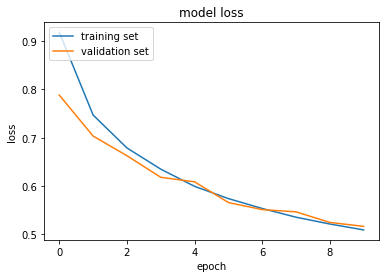

In [17]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Provavelmente temos um underfitting... tentando de novo

In [18]:
model2 = Model(inputs=inputs, outputs=model.layers[-2].output)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
Total params: 25,636,712
Trainable params: 2,049,000
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
feat_vectors_train = model2.predict(train_generator)
feat_vectors_valid = model2.predict(valid_generator)
feat_vectors_test = model2.predict(test_generator)

17/17 [==============================] - 3s 176ms/step


In [20]:
len(feat_vectors_train[0])

1000

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy import stats

clfsvm = SVC(kernel="rbf", random_state = 1)

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(1, 2)}

In [22]:
from sklearn.metrics import make_scorer, f1_score
f1 = make_scorer(f1_score)

In [27]:
rand_search = RandomizedSearchCV(clfsvm, param_distributions = rand_list, n_iter = 20, cv=3,n_jobs = 4, random_state = 42, scoring = f1) 
rand_search.fit(feat_vectors_train, y_train) 

rand_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning,


{'C': 5.745401188473625, 'gamma': 2.9014286128198323}

In [28]:
clfsvm.fit(feat_vectors_train,y_train)

SVC(random_state=1)

In [31]:
rand_search.cv_results_

{'mean_fit_time': array([3.76299032, 3.6970799 , 3.64102077, 3.7282997 , 3.59086871,
        3.50876546, 3.59067297, 3.63276792, 3.98699919, 3.5772117 ,
        3.5981613 , 3.68370652, 3.647036  , 3.59344721, 3.58748595,
        3.60640709, 3.57045849, 3.56739672, 3.53198536, 3.63365547]),
 'std_fit_time': array([0.13622683, 0.18392578, 0.09976985, 0.06981013, 0.10413248,
        0.24075947, 0.01538848, 0.05552602, 0.17228873, 0.19140512,
        0.09788273, 0.05960949, 0.03633425, 0.21363827, 0.11806611,
        0.21872037, 0.13756973, 0.0941614 , 0.08788936, 0.07131601]),
 'mean_score_time': array([2.51313734, 2.43464843, 2.46871591, 2.44375269, 2.60235445,
        2.45766322, 2.643375  , 2.55702901, 2.58059764, 2.43751629,
        2.46740341, 2.50547512, 2.52355019, 2.62245679, 2.39720384,
        2.40759905, 2.59481589, 2.37693119, 2.55273875, 2.08123104]),
 'std_score_time': array([0.07916285, 0.15101427, 0.10414821, 0.14313496, 0.11402005,
        0.15316957, 0.08882368, 0.271133

Avaliação de performance com os dados de teste

In [32]:
clfsvm = SVC(kernel="rbf", random_state = 1,C=5.74,gamma=2.79)
clfsvm.fit(feat_vectors_train,y_train)
y_pred = clfsvm.predict(feat_vectors_test)

In [33]:
print(classification_report(y_test,y_pred))

                         precision    recall  f1-score   support

          advertisement       0.46      0.89      0.61       171
                  email       0.55      0.26      0.36       193
scientific _publication       0.29      0.19      0.23       170

               accuracy                           0.44       534
              macro avg       0.43      0.45      0.40       534
           weighted avg       0.44      0.44      0.40       534

